# 5.2 Basic data transforms
This lesson covers adding and renaming columns

**5.2.1 Adding new columns**

The lesson covers adding new variables (columns) to a data frame, or applying transformations to existing columns.

**EXAMPLE DATA**

For our example data, we will use air quality measurements with missing data and
non-standard date formatting, for the year 1973:

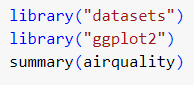

In [1]:
library("datasets")
library("ggplot2")
summary(airquality)

     Ozone           Solar.R           Wind             Temp      
 Min.   :  1.00   Min.   :  7.0   Min.   : 1.700   Min.   :56.00  
 1st Qu.: 18.00   1st Qu.:115.8   1st Qu.: 7.400   1st Qu.:72.00  
 Median : 31.50   Median :205.0   Median : 9.700   Median :79.00  
 Mean   : 42.13   Mean   :185.9   Mean   : 9.958   Mean   :77.88  
 3rd Qu.: 63.25   3rd Qu.:258.8   3rd Qu.:11.500   3rd Qu.:85.00  
 Max.   :168.00   Max.   :334.0   Max.   :20.700   Max.   :97.00  
 NA's   :37       NA's   :7                                       
     Month            Day      
 Min.   :5.000   Min.   : 1.0  
 1st Qu.:6.000   1st Qu.: 8.0  
 Median :7.000   Median :16.0  
 Mean   :6.993   Mean   :15.8  
 3rd Qu.:8.000   3rd Qu.:23.0  
 Max.   :9.000   Max.   :31.0  
                               

**SCENARIO**

We are asked to convert this non-standard date representation into a new, more useful
date column for queries and plotting.

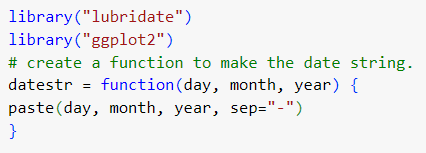

In [2]:
library("lubridate")
library("ggplot2")
# create a function to make the date string.
datestr = function(day, month, year) {
paste(day, month, year, sep="-")
}


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




**Base R solution**

In base R, we create new columns by assigning to them:

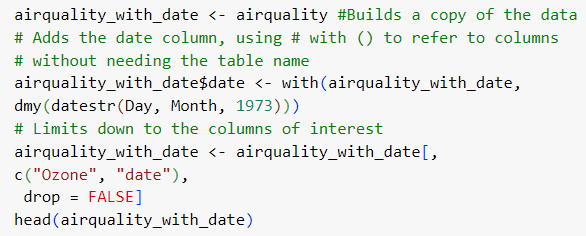

In [3]:
airquality_with_date <- airquality #Builds a copy of the data
# Adds the date column, using # with () to refer to columns
# without needing the table name
airquality_with_date$date <- with(airquality_with_date,
dmy(datestr (Day, Month, 1973)))
# Limits down to the columns of interest
airquality_with_date <- airquality_with_date[,
c("Ozone", "date"),
drop = FALSE]
head(airquality_with_date)

,Ozone,date
,<int>,<date>
1,41,1973-05-01
2,36,1973-05-02
3,12,1973-05-03
4,18,1973-05-04
5,NA,1973-05-05
6,28,1973-05-06


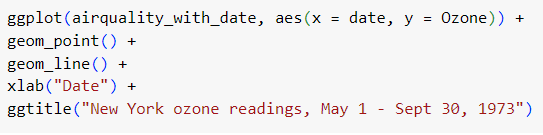

Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”


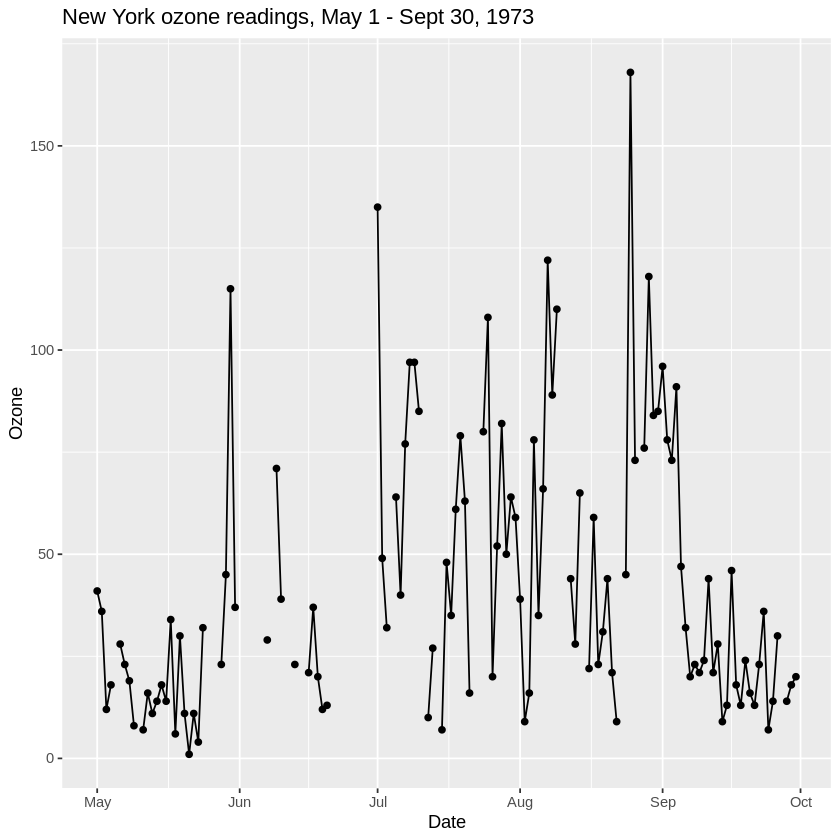

In [5]:
ggplot(airquality_with_date, aes(x = date, y = Ozone)) +
geom_point() +
geom_line() +
xlab("Date") +
ggtitle("New York ozone readings, May 1 - Sept 30, 1973")

Base R has had transform-style (or pipeable) versions of these basic operators for
quite some time (just no pipe!). Let’s work the example again in that style:

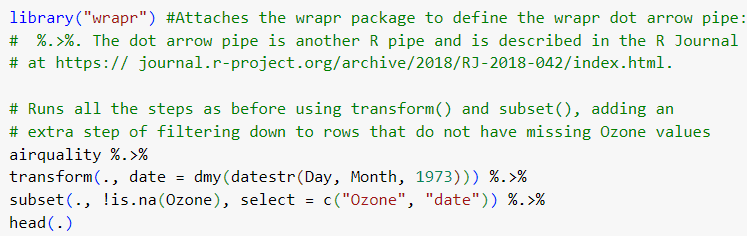

In [9]:
install.packages("wrapr")
library("wrapr") #Attaches the wrapr package to define the wrap dot arrow pipe:
# %.>%. The dot arrow pipe is another R pipe and is described in the R Journal
# at https:// journal.r-project.org/archive/2018/RJ-2018-042/index.html.
# Runs all the steps as before using transform() and subset (), adding an
# extra step of filtering down to rows that do not have missing Ozone values
airquality %.>%
transform(., date = dmy (datestr(Day, Month, 1973))) %.>%
subset(., !is.na(Ozone), select = c("Ozone","date")) %.>%
head(.)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,Ozone,date
,<int>,<date>
1,41,1973-05-01
2,36,1973-05-02
3,12,1973-05-03
4,18,1973-05-04
6,28,1973-05-06
7,23,1973-05-07


**data.table solution**

data.table uses := to show column alterations or creations that are supposed to
happen “in place” (the data.table at hand gets altered, instead of a new one being
created).

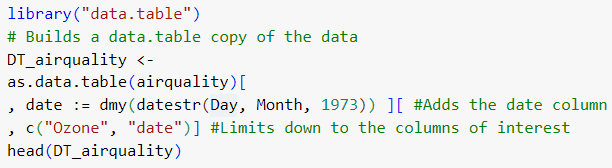

In [16]:
library ("data.table")
# Builds a data. table copy of the data
DT_airquality <-
as.data.table(airquality)[
, date := dmy(datestr(Day, Month, 1973)) ][ #Adds the date column
, c("Ozone", "date")] #Limits down to the columns of interest
head(DT_airquality)

Ozone,date
<int>,<date>
41,1973-05-01
36,1973-05-02
12,1973-05-03
18,1973-05-04
NA,1973-05-05
28,1973-05-06


**dplyr solution**

dplyr users will remember that in dplyr, new columns are produced with the
mutate() command :

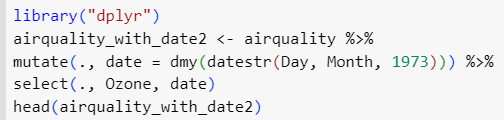

In [17]:
library ("dplyr")
airquality_with_date2 <- airquality %>%
mutate(., date = dmy (datestr (Day, Month, 1973))) %>%
select (., Ozone, date)
head(airquality_with_date2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:wrapr’:

    coalesce


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,Ozone,date
,<int>,<date>
1,41,1973-05-01
2,36,1973-05-02
3,12,1973-05-03
4,18,1973-05-04
5,NA,1973-05-05
6,28,1973-05-06


**THE SCENARIO CONTINUED**

Notice the original Ozone graph had holes in the data, due to missing values. We will
try to fix this by propagating the last known Ozone reading forward to the dates with
missing values.

The zoo package supplies a function called na.locf(), which is designed to solve
our issue. We will show how to apply this function now.

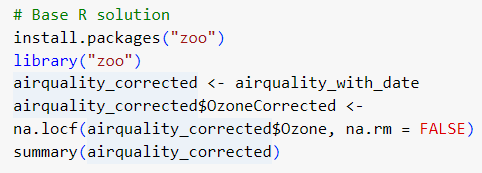

In [21]:
# Base R solution
install.packages("zoo")
library("zoo")
airquality_corrected <- airquality_with_date
airquality_corrected$OzoneCorrected <-
na.locf(airquality_corrected$Ozone, na.rm = FALSE)
summary(airquality_corrected)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




     Ozone             date            OzoneCorrected  
 Min.   :  1.00   Min.   :1973-05-01   Min.   :  1.00  
 1st Qu.: 18.00   1st Qu.:1973-06-08   1st Qu.: 16.00  
 Median : 31.50   Median :1973-07-16   Median : 30.00  
 Mean   : 42.13   Mean   :1973-07-16   Mean   : 39.78  
 3rd Qu.: 63.25   3rd Qu.:1973-08-23   3rd Qu.: 52.00  
 Max.   :168.00   Max.   :1973-09-30   Max.   :168.00  
 NA's   :37                                            

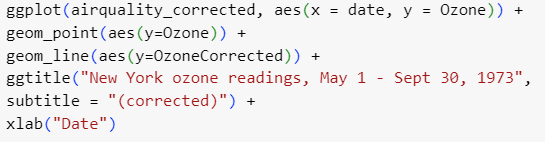

Warning message:
“Removed 37 rows containing missing values (`geom_point()`).”


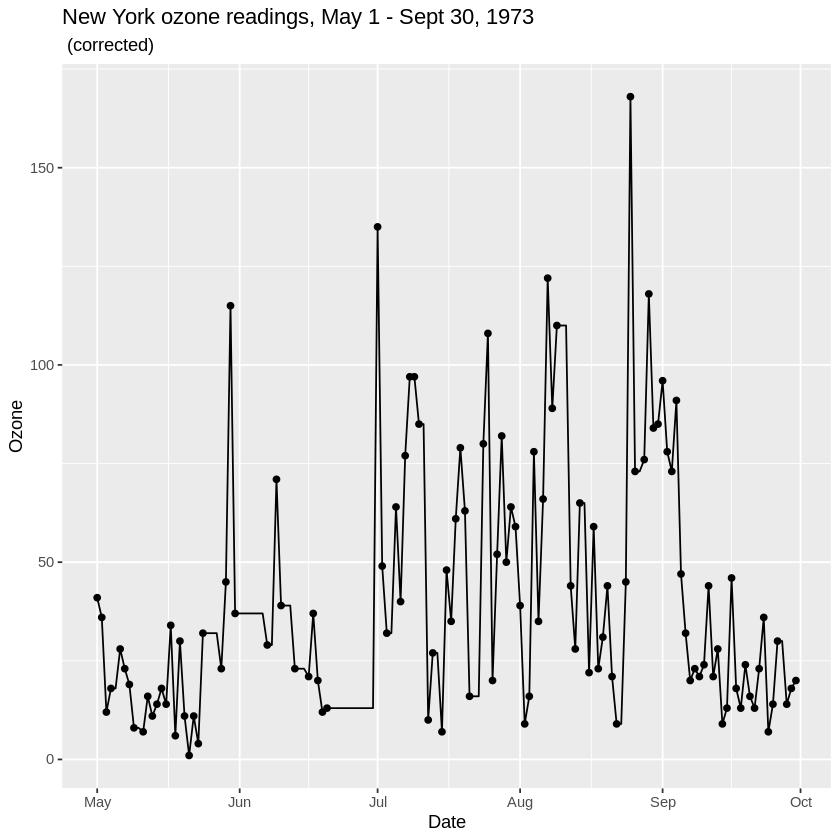

In [25]:
ggplot(airquality_corrected, aes(x = date, y = Ozone)) +
geom_point(aes(y=Ozone)) +
geom_line(aes(y=OzoneCorrected)) +
ggtitle("New York ozone readings, May 1 - Sept 30, 1973",
subtitle = " (corrected)") +
xlab("Date")

**USE NA.RM = FALSE**   Always use na.rm = FALSE with na.locf(); otherwise, it
may delete initial NA elements from your data.

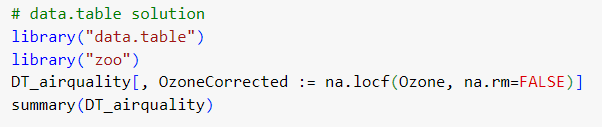

In [27]:
# data.table solution
library("data.table")
library("zoo")
DT_airquality[, OzoneCorrected := na.locf(Ozone, na.rm=FALSE)]
summary(DT_airquality)

     Ozone             date            OzoneCorrected  
 Min.   :  1.00   Min.   :1973-05-01   Min.   :  1.00  
 1st Qu.: 18.00   1st Qu.:1973-06-08   1st Qu.: 16.00  
 Median : 31.50   Median :1973-07-16   Median : 30.00  
 Mean   : 42.13   Mean   :1973-07-16   Mean   : 39.78  
 3rd Qu.: 63.25   3rd Qu.:1973-08-23   3rd Qu.: 52.00  
 Max.   :168.00   Max.   :1973-09-30   Max.   :168.00  
 NA's   :37                                            

Notice that data.table performed the correction “in place,” in DT_airquality
instead of producing a new data.frame.

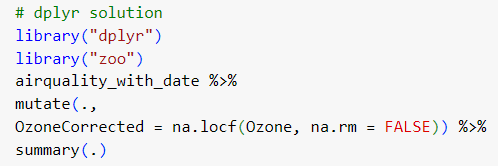

In [30]:
# dplyr solution
library("dplyr")
library("zoo")
airquality_with_date %>%
mutate(.,
OzoneCorrected = na.locf (Ozone, na.rm = FALSE)) %>%
summary(.)

     Ozone             date            OzoneCorrected  
 Min.   :  1.00   Min.   :1973-05-01   Min.   :  1.00  
 1st Qu.: 18.00   1st Qu.:1973-06-08   1st Qu.: 16.00  
 Median : 31.50   Median :1973-07-16   Median : 30.00  
 Mean   : 42.13   Mean   :1973-07-16   Mean   : 39.78  
 3rd Qu.: 63.25   3rd Qu.:1973-08-23   3rd Qu.: 52.00  
 Max.   :168.00   Max.   :1973-09-30   Max.   :168.00  
 NA's   :37                                            

**5.2.2 Other simple operations**

A number of additional simple operations commonly used in working with data are
available—in particular, renaming columns by altering the column names directly,
and also removing columns by assigning NULL. We will show these briefly:

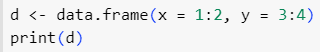

In [31]:
d <- data.frame(x = 1:2, y = 3:4)
print(d)

  x y
1 1 3
2 2 4


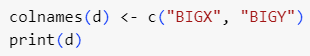

In [33]:
colnames(d) <- c("BIGX", "BIGY")
print(d)

  BIGX BIGY
1    1    3
2    2    4


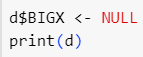

In [35]:
d$BIGX <- NULL
print(d)

  BIGY
1    3
2    4
